# Project 03: Info-Bit-Audit - Forensic Information Theory

**Author:** Davi Bonetto  
**Course Module:** 01-Janeiro-Math  

## 1. Introduction: Measuring the Unseen

Information Theory is the mathematical framework that quantifies communication, storage, and probability distributions. Founded by Claude Shannon in 1948, it provides the tools to measure "surprise" and "redundancy" in data.

In this project, we build a **Forensic Analysis Tool** to distinguish between structured data (like English text) and high-entropy noise (like random keys or encrypted files).

### 1.1 Shannon Entropy (The Bit Count)
Entropy $H(X)$ measures the average amount of information (in bits) required to encode a variable $X$. High entropy means high unpredictability.

$$ H(X) = - \sum_{i} P(x_i) \log_2 P(x_i) $$

### 1.2 Kullback-Leibler Divergence (The Distance)
KL-Divergence $D_{KL}(P || Q)$ measures the inefficiency incurred by assuming the data follows distribution $Q$ when it actually follows $P$. It is often called "Relative Entropy".

$$ D_{KL}(P || Q) = \sum_{i} P(x_i) \log \left( \frac{P(x_i)}{Q(x_i)} \right) $$

## 2. The 'InfoMetrics' Engine

We implement the core metrics from scratch using `numpy` for vectorization.
**Constraint:** We do NOT use `scipy.stats`.

In [1]:
import numpy as np
import math
import collections
import matplotlib.pyplot as plt
import string

class InfoMetrics:
    @staticmethod
    def get_distribution(data, vocabulary=None):
        """
        Converts data (string/list) into a probability distribution.
        If vocabulary is provided, ensures all keys are present (smoothing).
        """
        counts = collections.Counter(data)
        total = sum(counts.values())

        # If specific vocabulary required (e.g., all alphabet chars)
        if vocabulary:
            dist = []
            for char in vocabulary:
                # Add small epsilon smoothing to avoid 0 probability later
                dist.append(counts.get(char, 0) + 1e-10)

            # Re-normalize
            dist = np.array(dist)
            return dist / dist.sum()

        # Natural distribution from data only
        probs = np.array(list(counts.values())) / total
        return probs

    @staticmethod
    def entropy(probs):
        """
        Calculates Shannon Entropy in bits.
        H(X) = -sum(p * log2(p))
        """
        # Filter out zero probabilities or use masked array to avoid log(0)
        probs = np.asarray(probs)
        probs = probs[probs > 0]

        return -np.sum(probs * np.log2(probs))

    @staticmethod
    def kl_divergence(p, q):
        """
        Calculates KL Divergence D(P || Q).
        P: True distribution
        Q: Approximated distribution
        """
        p = np.asarray(p)
        q = np.asarray(q)

        # Safety: eps for numerical stability
        docs_eps = 1e-10
        p = np.clip(p, docs_eps, 1)
        q = np.clip(q, docs_eps, 1)

        # D_KL = sum(p * log(p/q))
        return np.sum(p * np.log(p / q))

    @staticmethod
    def cross_entropy(p, q):
        """
        H(P, Q) = H(P) + D_KL(P || Q)
        """
        return InfoMetrics.entropy(p) + InfoMetrics.kl_divergence(p, q)

# -- Verification --
# Entropy of a fair coin (50/50) should be 1 bit
print(f"Entropy (Fair Coin): {InfoMetrics.entropy([0.5, 0.5]):.4f} bits")
# Entropy of a biased coin (90/10) should be lower (less surprise)
print(f"Entropy (Biased Coin): {InfoMetrics.entropy([0.9, 0.1]):.4f} bits")

Entropy (Fair Coin): 1.0000 bits
Entropy (Biased Coin): 0.4690 bits


## 3. Forensic Case Study: Shakespeare vs. The Monkey

The **Infinite Monkey Theorem** states that a monkey hitting keys at random will eventually type the complete works of William Shakespeare. However, the *entropy* of the monkey's output will be vastly different from the Bard's.

- **Real Text:** Structures, grammar, and common letters ('e', 'a') reduce entropy.
- **Random Text:** Uniform distribution maximizes entropy.

In [2]:
def generate_random_text(length, vocabulary=string.ascii_lowercase + ' '):
    """Simulates the monkey."""
    return ''.join(np.random.choice(list(vocabulary), size=length))

# 1. Load Real Text (Hamlet excerpt)
shakespeare_text = """
to be or not to be that is the question whether it is nobler in the mind to suffer
the slings and arrows of outrageous fortune or to take arms against a sea of troubles
and by opposing end them to die to sleep no more and by a sleep to say we end
the heart-ache and the thousand natural shocks that flesh is heir to tis a consummation
devoutly to be wish'd to die to sleep to sleep perchance to dream ay there's the rub
for in that sleep of death what dreams may come when we have shuffled off this mortal coil
must give us pause there's the respect that makes calamity of so long life
""".lower().replace('\n', ' ')
# Cleaning simple punctuation for fair comparisons
shakespeare_text = ''.join([c for c in shakespeare_text if c in string.ascii_lowercase + ' '])

# 2. Generate Random Text (Same length)
monkey_text = generate_random_text(len(shakespeare_text))

# 3. Compute Metrics
vocab = list(string.ascii_lowercase + ' ')
p_real = InfoMetrics.get_distribution(shakespeare_text, vocab)
p_monkey = InfoMetrics.get_distribution(monkey_text, vocab)
p_uniform = np.ones(len(vocab)) / len(vocab) # Theoretical uniform dist

entropy_real = InfoMetrics.entropy(p_real)
entropy_monkey = InfoMetrics.entropy(p_monkey)

print(f"Entropy (Shakespeare): {entropy_real:.4f} bits/char")
print(f"Entropy (Monkey):      {entropy_monkey:.4f} bits/char")
print(f"Max Possible Entropy:  {math.log2(len(vocab)):.4f} bits/char")

# KL Divergence: How far is Shakespeare from complete randomness?
kl_real_vs_uniform = InfoMetrics.kl_divergence(p_real, p_uniform)
print(f"KL Divergence (Real || Uniform): {kl_real_vs_uniform:.4f} nats")

Entropy (Shakespeare): 3.9737 bits/char
Entropy (Monkey):      4.7081 bits/char
Max Possible Entropy:  4.7549 bits/char
KL Divergence (Real || Uniform): 0.5415 nats


## 4. Visualization: The Fingerprint of Language

We visualize the character frequency distributions. Note the distinct "fingerprint" of English (high 'e', 't', 'space') versus the flat noise of the monkey.

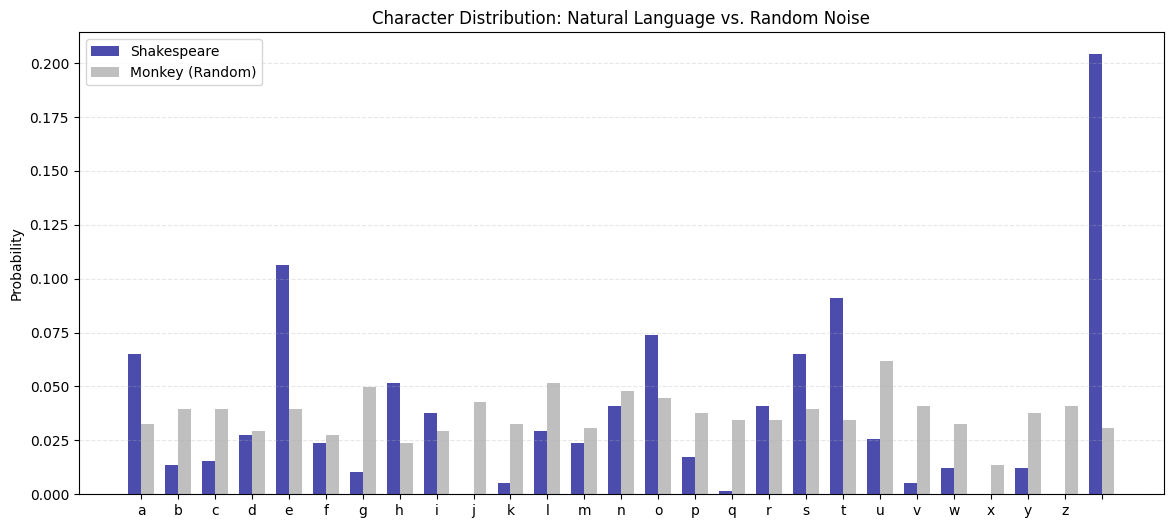

In [3]:
indices = np.arange(len(vocab))
width = 0.35

plt.figure(figsize=(14, 6))

plt.bar(indices - width/2, p_real, width, label='Shakespeare', color='darkblue', alpha=0.7)
plt.bar(indices + width/2, p_monkey, width, label='Monkey (Random)', color='gray', alpha=0.5)

plt.ylabel('Probability')
plt.title('Character Distribution: Natural Language vs. Random Noise')
plt.xticks(indices, vocab)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

## 5. Conclusion

Entropy is a powerful forensic metric.

1.  **Low Entropy:** Indicates structure, language, or redundancy. In cybersecurity, a file with unexpectedly low entropy might be a log file or source code.
2.  **Max Entropy:** Indicates randomness or **Encryption**. A properly encrypted file should look indistinguishable from random noise (high entropy).

By measuring $D_{KL}$, we can quantify exactly *how much* a signal deviates from a baseline expectation, allowing for automated anomaly detection.